In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import RFE

In [3]:
df = pd.read_csv("D:\\Descargas\\archive (1)\\superstore_data.csv")
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


In [4]:
df.shape

(2240, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
df.isnull().sum()

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

In [7]:
df.Income = df.Income.fillna(df.Income.mean())

In [8]:
df.duplicated().sum()

0

In [9]:
df["Age"] = 2022 - df["Year_Birth"]

In [10]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

l_years = []
for i in df["Dt_Customer"]:
  f = dt.datetime.now().date() - i.date()
  l_years.append(f.days/365)
df.insert(loc=23, column="Year_Dt", value = l_years)

In [11]:
df = df.drop(["Id", "Year_Birth", "Dt_Customer"], axis=1)

##### TRANSFORMACIÓN DE LAS VARIABLES DUMMY

In [12]:
df_c_dummy = df.columns[df.dtypes == object]
df_dummy = pd.get_dummies(data= df, prefix = df_c_dummy, drop_first = True)

In [13]:
# Para acelerar los procesos computacionales convertimos todos los elementos al tipo de archivo float
df_dummy = df_dummy.astype(float)
df_dummy.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,84835.0,0.0,0.0,0.0,189.0,104.0,379.0,111.0,189.0,218.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,57091.0,0.0,0.0,0.0,464.0,5.0,64.0,7.0,0.0,37.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,67267.0,0.0,1.0,0.0,134.0,11.0,59.0,15.0,2.0,30.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,32474.0,1.0,1.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,21474.0,1.0,0.0,0.0,6.0,16.0,24.0,11.0,0.0,34.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### ESCALADO DE LAS VARIABLES

In [14]:
X = df_dummy.drop("Response", axis=1)
y = df["Response"].values.reshape(-1,1)

In [15]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
y = scaler_y.fit_transform(y) 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### BALANCEO DE LAS CLASES

Si una clase es dominante en cantidad respecto al otro, puede ocacionar cesgo, para evitar eso balanceamos los datos.

df_dummy.Response.value_counts()

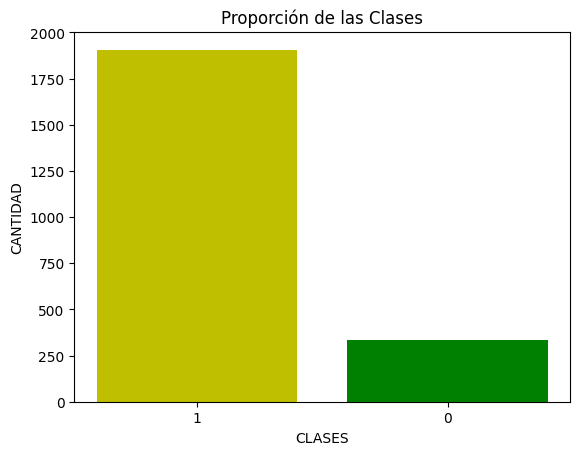

In [17]:
plt.bar(x=df.Response.astype(str).unique(), height = df.Response.value_counts(), color = ["y", "g"]);
plt.title("Proporción de las Clases")
plt.xlabel("CLASES")
plt.ylabel("CANTIDAD")
plt.show()

In [18]:
smote = SMOTETomek(random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

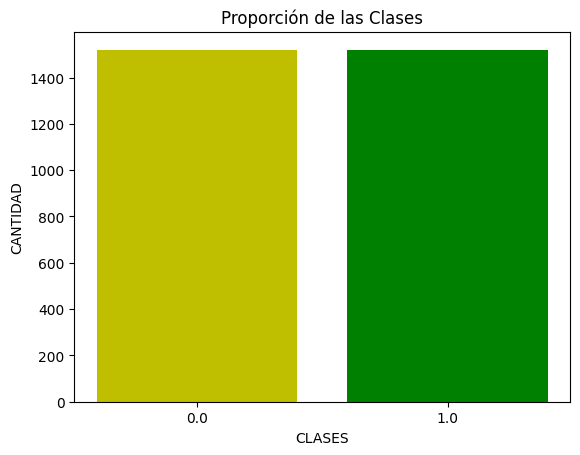

In [19]:
y_df = pd.DataFrame(y_train_sm)

plt.bar(x=y_df[0].astype(str).unique(), height = y_df.value_counts(), color = ["y", "g"]);
plt.title("Proporción de las Clases")
plt.xlabel("CLASES")
plt.ylabel("CANTIDAD")
plt.show()

##### ARBOL DE DECISION

In [29]:
model = DecisionTreeClassifier()

# Define el rango de valores para los parámetros a ser optimizados
param_dist = {
    
    "max_depth": np.arange(3,11,2),
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(1, 10, 2)
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10, cv=10, n_jobs=-1
)

random_search.fit(X_train_sm, y_train_sm);

In [30]:
best_parameters = random_search.best_params_
print("best_parameters: ", best_parameters)
best_accuracy = random_search.best_score_
print("best_accuracy: ", best_accuracy)

best_parameters:  {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 9}
best_accuracy:  0.8582236842105264


In [31]:
tree = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=3, max_depth=9)
tree.fit(X_train_sm, y_train_sm)

y_train_pred = tree.predict(X_train_sm)
y_test_pred = tree.predict(X_test)

In [32]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_test_pred)*100))

Accuracy: 79.69 %


In [33]:
accuracies = cross_val_score(estimator = tree, X = X_train_sm, y = y_train_sm, cv = 10, n_jobs=-1)
print("Validación Cruzada: {:.2f} %".format(accuracies.mean()*100))

Validación Cruzada: 85.86 %


In [34]:
print("Metrics:\n {}".format(classification_report(y_test, y_test_pred)))

Metrics:
               precision    recall  f1-score   support

         0.0       0.93      0.83      0.87       384
         1.0       0.37      0.61      0.46        64

    accuracy                           0.80       448
   macro avg       0.65      0.72      0.67       448
weighted avg       0.85      0.80      0.82       448



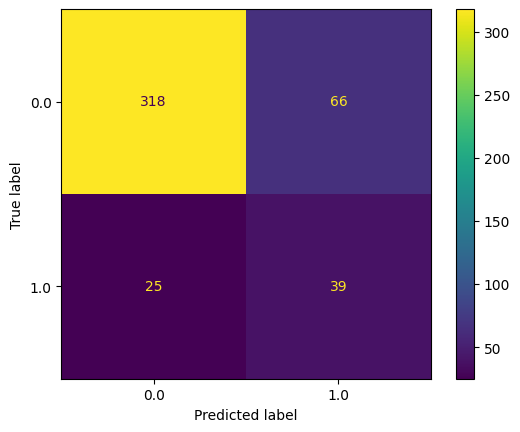

In [36]:
# MATRIZ DE CONFUSION
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

##### CURVA ROC

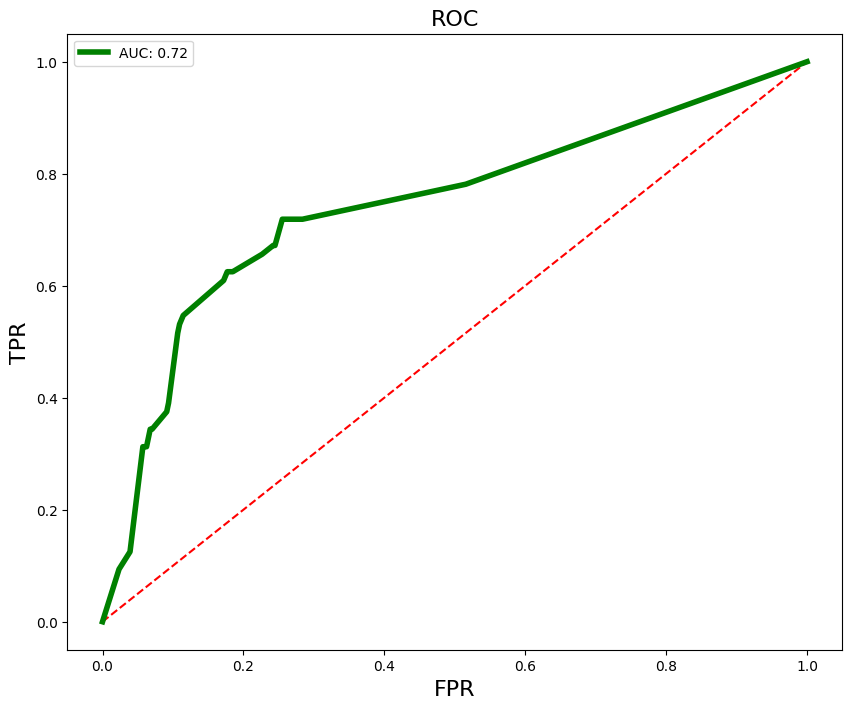

In [37]:
plt.figure(figsize = (10,8))
plt.plot([0,1],[0,1], "r--")

probs = tree.predict_proba(X_test)

probs = probs[:, 1]
fpr,tpr, thresholds = roc_curve(y_test, probs) 
roc_auc = roc_auc_score(y_test, y_test_pred)

label = "AUC: " + "{:.2F}".format(roc_auc)
plt.plot(fpr, tpr, c = "g", label=label, linewidth=4)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.title("ROC", fontsize=16)
plt.legend();

#####  VEAMOS SI AUN PODEMOS MEJORAR UN POCO EL MODELO

SELECCION DE VARIABLES

Seleccionamos las variables mas significativas para el modelo.

In [121]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression()
selector = RFE(estimator=estimator, n_features_to_select = 22, step=1)
selector.fit(X_train_sm, y_train_sm.ravel())

print(selector.support_)
print(selector.ranking_)
best_variables = selector.support_

[False  True  True  True  True False  True  True False  True  True  True
  True  True  True  True False  True  True  True  True  True  True False
  True False  True  True False]
[2 1 1 1 1 4 1 1 6 1 1 1 1 1 1 1 7 1 1 1 1 1 1 8 1 5 1 1 3]


In [122]:
model = DecisionTreeClassifier()

param_dist = {
    
    "max_depth": np.arange(3,11,1),
    "min_samples_split": np.arange(2, 10, 1),
    "min_samples_leaf": np.arange(1, 10, 1)
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10, cv=10, n_jobs=-1
)

random_search.fit(X_train_sm.iloc[:, best_variables], y_train_sm);

In [123]:
best_parameters = random_search.best_params_
print("best_parameters: ", best_parameters)
best_accuracy = random_search.best_score_
print("best_accuracy: ", best_accuracy)

best_parameters:  {'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 10}
best_accuracy:  0.85625


In [124]:
tree = DecisionTreeClassifier(min_samples_split=8, min_samples_leaf=2, max_depth=10)
tree.fit(X_train_sm.iloc[:, best_variables], y_train_sm)

y_train_pred = tree.predict(X_train_sm.iloc[:, best_variables])
y_test_pred = tree.predict(X_test.iloc[:, best_variables])

In [125]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_test_pred)*100))

Accuracy: 81.70 %


In [126]:
accuracies = cross_val_score(estimator = tree, X = X_train_sm.iloc[:, best_variables], y = y_train_sm, cv = 10, n_jobs=-1)
print("Validación Cruzada: {:.2f} %".format(accuracies.mean()*100))

Validación Cruzada: 85.36 %


In [127]:
print("Metrics:\n {}".format(classification_report(y_test, y_test_pred)))

Metrics:
               precision    recall  f1-score   support

         0.0       0.91      0.88      0.89       384
         1.0       0.38      0.45      0.41        64

    accuracy                           0.82       448
   macro avg       0.64      0.67      0.65       448
weighted avg       0.83      0.82      0.82       448



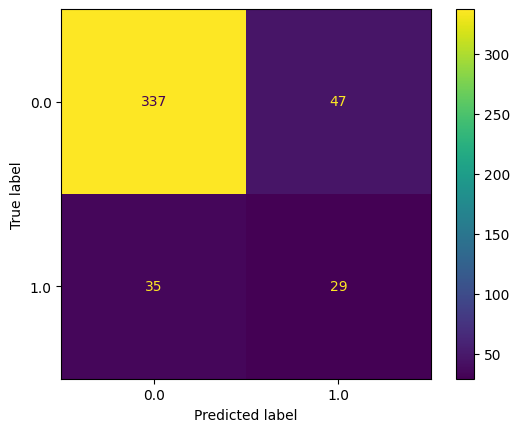

In [128]:
# MATRIZ DE CONFUSION
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

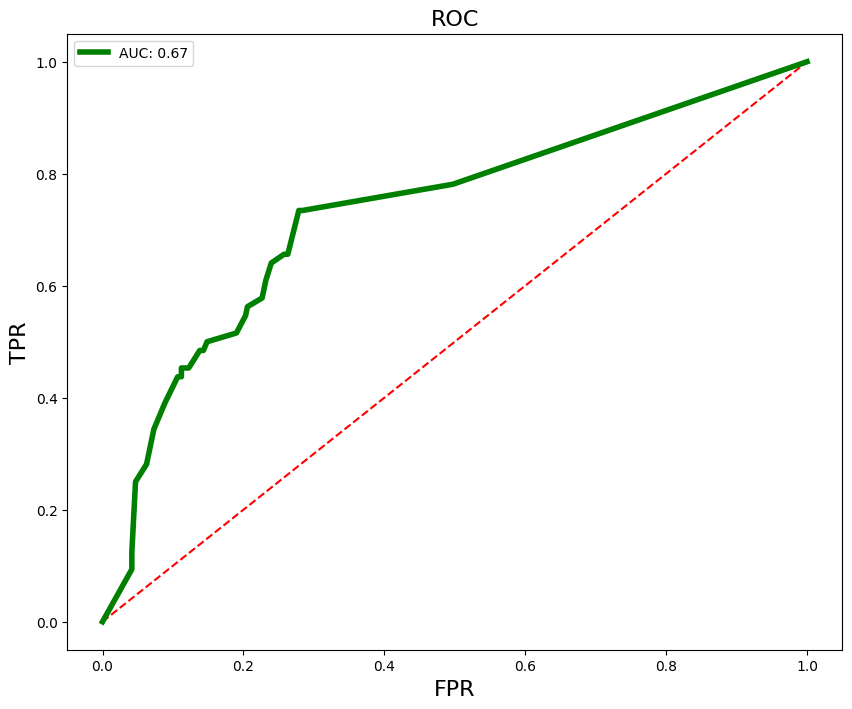

In [129]:
plt.figure(figsize = (10,8))
plt.plot([0,1],[0,1], "r--")

probs = tree.predict_proba(X_test.iloc[:, best_variables])

probs = probs[:, 1]
fpr,tpr, thresholds = roc_curve(y_test, probs) 
roc_auc = roc_auc_score(y_test, y_test_pred)

label = "AUC: " + "{:.2F}".format(roc_auc)
plt.plot(fpr, tpr, c = "g", label=label, linewidth=4)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.title("ROC", fontsize=16)
plt.legend();